In [374]:
import pandas as pd
import matplotlib.axes as ax
%matplotlib inline
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

## Executive Summary

Military coups have existed since as far as 800 BC. They occur when an illegitimate claimant to power seizes power within a state for at least seven days. Although coups have been fewer in recent time, there have been about 460 coups attempts since 1950 (of which roughly 50% were successful). In past century, coups have been mostly common in Africa and the Americas, with fewer coups occurring Europe. Most of the coup attempts in the past 60 years occurred in the 1960s, at the same times majority of African nations gained independece from the Europeans. However, in recent times, successful coups have been less frequent either because governments have developed new methods in containing the usurpers, or because recent coup leaders are less strategic in claiming the throne. That, however, is a data science question for another project. 

Although successful coups are more prominent, attempted coups are more frequent than one would expect. In the past 16 years along, there have been 30 attempted coups (seven successful), with majority occurring in Africa. Many of these coup attemps did not gain as much international attention as that of Turkey that occurred July 15, 2016. The recent coups attempts causes one to wonder if there ways to predict a coup attempt (successful or not), given the social and polical climate in a state.

Problem Statement: Considerig social and political instabilities that have occured in recent times, I want predict the likelihood of a coup d'etat within a country, given specific economic, political and social factors.

- Economic factors: income per capita, growth rate
- Social factors: accounts of ethnic violence, reglious, linguistic, and ethnic fractionalization, fatalities from 
  violence, urbanisation
- Political factors: polity score, length of stay for incumbent head of state


For my analysis, I will be using a Random Forest Classifier model to predict the occurrence of a coup. The dataset consist of 3046 observations and 20 variables. 
  

In [375]:
# I'm still in the process of building my model. I'll also add more visualizations

In [376]:
coup = pd.read_csv("../assets/csv/Coups.csv")
stab = pd.read_csv("../assets/csv/Politicalinstability2.csv")
polity = pd.read_csv("../assets/csv/polity.csv")
leaders = pd.read_csv("../assets/csv/leaders.csv")
urban = pd.read_csv("../assets/csv/urbanpop.csv")
gdp = pd.read_csv("../assets/csv/Realpercapitagdp.csv")
growth = pd.read_csv("../assets/csv/GDPgrowth.csv")

In [377]:
#coup.head()

In [378]:
# Summing scoup1(successful coups) and acoup1(attempted coups) to generate sumcoup
# I want a columns with binary variables that indicates coup (successful and attempted) or no coup
coup["sumcoup"] = coup["scoup1"] + coup["atcoup2"]

# To make a bianary column
coupbin = []
for i in coup["sumcoup"].tolist():
    if i > 0:
        coupbin.append(1)
    if i == 0:
        coupbin.append(0)
coup["Coup"] = coupbin

In [379]:
# Dropping unnecessary columns
coup.drop(["scoup1", "atcoup2", "sumcoup"], axis=1, inplace=True)

In [514]:
coup.to_csv("../assets/csv/couprv.csv")

In [380]:
#stab.head()

In [381]:
# To covert the variables in PTYPE to dummy variables 
dummies = pd.get_dummies(stab["PTYPE"])
stab = stab[["COUNTRY", "YEAR", "GENDEATHMAG", "ETHMAGFATAL", 
             "ETHMAGFIGHT", "REVMAGFATAL", "REVMAGFIGHT"]].join(dummies)

stab.columns = ["COUNTRY", "YEAR", "GENDEATHMAG", "ETHMAGFATAL", 
                "ETHMAGFIGHT", "REVMAGFATAL", "REVMAGFIGHT", "NONE",
                "ETH", "REV", "GEN"]

In [382]:
# To avoid repetition of rows, I want to group the dataframes bq
aggMap = { "NONE" : "max", "ETH" : "max", "REV" : "max", 
           "GEN" : "max", "GENDEATHMAG" : "max", 
           "ETHMAGFATAL" : "max", "ETHMAGFIGHT" : "max", 
           "REVMAGFATAL" : "max", "REVMAGFIGHT" : "max" }

stabGrouped = stab.groupby(["COUNTRY","YEAR"]).agg(aggMap).reset_index()

In [383]:
#stabGrouped.head()

In [384]:
stab.head()

COUNTRY  YEAR  GENDEATHMAG  ETHMAGFATAL  ETHMAGFIGHT  REVMAGFATAL  \
0  Afghanistan  1955          0.0            0            0            0   
1  Afghanistan  1956          0.0            0            0            0   
2  Afghanistan  1957          0.0            0            0            0   
3  Afghanistan  1958          0.0            0            0            0   
4  Afghanistan  1959          0.0            0            0            0   

   REVMAGFIGHT  NONE  ETH  REV  GEN  
0            0   1.0  0.0  0.0  0.0  
1            0   1.0  0.0  0.0  0.0  
2            0   1.0  0.0  0.0  0.0  
3            0   1.0  0.0  0.0  0.0  
4            0   1.0  0.0  0.0  0.0

In [385]:
# Joining the political stabilty and coup tables 
coup1 = coup.merge(stabGrouped, how="inner", left_on=["country", "year"], right_on=["COUNTRY", "YEAR"])

In [386]:
# dropping the unnecessary columns and setting all columns to lower case for easier manipulation in the future
coup1.drop(["COUNTRY", "YEAR"], axis=1, inplace=True)
coup1.columns = map(str.lower, coup1.columns)

In [387]:
#coup1.head()

In [388]:
#polity.head()

In [389]:
# Dropping unnecessary variables
polity.drop(["flag", "fragment", "democ", "autoc", "polity"], axis=1, inplace=True)

In [390]:
# Merging polity table with coup1 table
coup2 = coup1.merge(polity, how="inner", left_on=["country", "year"], right_on=["country", "year"])

In [391]:
#coup2.head()

In [392]:
#leaders.head()

In [393]:
# Merging coup2 and leaders
coup3 = coup2.merge(leaders, how="inner", left_on=["country", "year"], right_on=["country", "year"])

In [394]:
#coup3.head()

In [395]:
#urban.head()

In [396]:
# I want to change the shape of the table, so the year columns become rows
Col1 = urban.columns[0]
Col2 = urban.columns[1:].tolist()
urban1 = pd.melt(urban, id_vars=(Col1), var_name="year", value_vars=(Col2), value_name="urbanpop")
urban1.sort_values(["country", "year"], inplace=True)

In [397]:
#urban1.head()

In [398]:
#gdp.head()

The gdp table shows the real per capita GDP of each country from 1969 to 2015.

In [399]:
# Also changing the shape of the table here
Col3 = gdp.columns[0]
Col4 = gdp.columns[1:].tolist()
gdp1 = pd.melt(gdp, id_vars=(Col3), var_name="year", value_vars=(Col4), value_name="gdppercap")
gdp1.sort_values(["country", "year"], inplace=True)

In [400]:
#gdp1.head()

In [401]:
# Cleaning the values in the gdp1 table
gdp1['gdppercap'] = gdp1['gdppercap'].str.replace('$', '')
gdp1['gdppercap'] = gdp1['gdppercap'].str.replace(',', '')

In [402]:
# Coverting the values to numeric
gdp1['gdppercap'] = gdp1['gdppercap'].convert_objects(convert_numeric=True)
gdp1.dtypes

/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


country       object
year          object
gdppercap    float64
dtype: object

In [403]:
#growth.head()

In [404]:
# Changing the shape of the table
Col5 = growth.columns[0]
Col6 = growth.columns[1:].tolist()
growth1 = pd.melt(growth, id_vars=(Col5), var_name="year", value_vars=(Col6), value_name="gdpgrowth")
growth1.sort_values(["country", "year"], inplace=True)

In [405]:
#growth1.head()

In [406]:
# Converting to numeric
growth1['gdpgrowth'] = growth1['gdpgrowth'].convert_objects(convert_numeric=True)
growth1.dtypes

/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


country       object
year          object
gdpgrowth    float64
dtype: object

In [407]:
# Joining tables again
Econ = gdp1.merge(growth1, how="inner", left_on=["country", "year"], right_on=["country", "year"])
Econ1 = Econ.merge(urban1, how="inner", left_on=["country", "year"], right_on=["country", "year"])

In [408]:
#Econ1.head()

In [409]:
#Econ1.dtypes

In [410]:
# Convert the year column to numeric
Econ1["year"] = Econ1["year"].convert_objects(convert_numeric=True)

/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


In [411]:
# Final join!
DF = Econ1.merge(coup3, how="inner", left_on=["country", "year"], right_on=["country", "year"])

In [412]:
#DF.head()

In [413]:
# Incorporating a new table into the dataframe
# Importing the csv file as a list of lists
# Converting the list to a data dictionary, with the countries being the keys and ethinic, linguistic, and religious
# fractionalization respectively serving as the values

path = "../assets/csv/diversity.csv"
import csv

def read_file(path):
    with open(path, 'r') as f:
        diversity = [row for row in csv.reader(f.read().splitlines())]
    return diversity

diversity = read_file(path)
diversity = diversity[1:]
#print diversity

def function(i):return (i[0], i[1:])
div_dict = map(function, diversity)
divDict = dict(div_dict)
#print myNewDict


In [414]:
# Matching the values from the dictionary to their respective countries

loc = DF["country"].tolist()


ethnicity = []
linguistic = []
religious = []


for i in loc:
    for country, ethnic in divDict.items():
        if i == country:
            ethnicity.append( ethnic[0] )
            linguistic.append( ethnic[1] )
            religious.append( ethnic[2] )

In [415]:
#Assigning these values to their respective columns
DF["ethnic"] = ethnicity
DF["linguistic"] = linguistic
DF["religious"] = religious

In [416]:
#DF.head()

In [417]:
DF.count()

country        3121
year           3121
gdppercap      3068
gdpgrowth      3068
urbanpop       3121
coup           3121
none           3121
revmagfight    3121
gendeathmag    3121
ethmagfatal    3121
revmagfatal    3121
eth            3121
ethmagfight    3121
rev            3121
gen            3121
polity2        3121
durable        3121
yip            3121
ethnic         3121
linguistic     3121
religious      3121
dtype: int64

In [418]:
# Drop rows with missing values (since they are relatively few)
# Drop the year columns since I won't be needing it for my analysis
DF.dropna(axis=0, how="any", inplace=True)
DF.drop(["year"], axis=1, inplace=True)

In [419]:
DF.shape

(3046, 20)

In [420]:
DF["coup"].value_counts()

0    2861
1     185
Name: coup, dtype: int64

In [421]:
# Converting year column to numeric
DF[["ethnic", "linguistic", "religious"]] = DF[["ethnic", "linguistic", "religious"]] \
                                            .convert_objects(convert_numeric=True)

/Users/Lola/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


In [422]:
#DF.dtypes

In [423]:
DF.head()cd

country  gdppercap  gdpgrowth  urbanpop  coup  none  revmagfight  \
1  Afghanistan      287.0       4.04     11.53     0   1.0            0   
2  Afghanistan      291.0       3.88     11.92     0   1.0            0   
3  Afghanistan      294.0       3.74     12.32     0   1.0            0   
4  Afghanistan      297.0       3.60     12.73     1   1.0            0   
5  Afghanistan      300.0       3.48     13.15     0   1.0            0   

   gendeathmag  ethmagfatal  revmagfatal  eth  ethmagfight  rev  gen  polity2  \
1          0.0            0            0  0.0            0  0.0  0.0       -7   
2          0.0            0            0  0.0            0  0.0  0.0       -7   
3          0.0            0            0  0.0            0  0.0  0.0       -7   
4          0.0            0            0  0.0            0  0.0  0.0       -7   
5          0.0            0            0  0.0            0  0.0  0.0       -7   

   durable  yip  ethnic  linguistic  religious  
1      6.0   37  0.7693      0.6141     0.2717  
2      7.0   38  0.7693      0.6141     0.2717  
3      8.0   39  0.7693      0.6141     0.2717  
4      9.0   40  0.7693      0.6141     0.2717  
5     10.0    1  0.7693      0.6141     0.2717

Variable|Description
--|--
country|Country Name
coup|1 = Coup(successful and attempted), 0 = No coup
gdppercap|GDP per capita 
gdpgrowth|GDP growth rate
urbanpop|Percentage of urban population
gendeathmag|Scaled annual number of deaths (range 0-5.0)
revmagfight|Scaled annual number of fatalities related to revolutionary fighting (range 0-4)
ethmagfatal|Scaled annual number of fatalities related to ethnic fighting (range 0-4)
revmagfatal|Scaled number of rebel combatants or activists in revolutionary war (range 0-4)
ethmagfight|Scaled number of rebel combatants or activists in ethnic war (range 0-4)
polity2|Polity scale ranging from +10 (strongly democratic) to -10 (strongly autocratic)
durable|
yip|Number of years head of state has been in power
none|No violence occured
eth|Indicates the occurence of an ethnic violence
rev|Indicates the occurence of a revolutionary violence
gen|Indicates the occurence of a genocide
ethnic| Ethnic Fractionalization
linguistic|Linguistic Fractionalization
religious| Religious Fractionalization

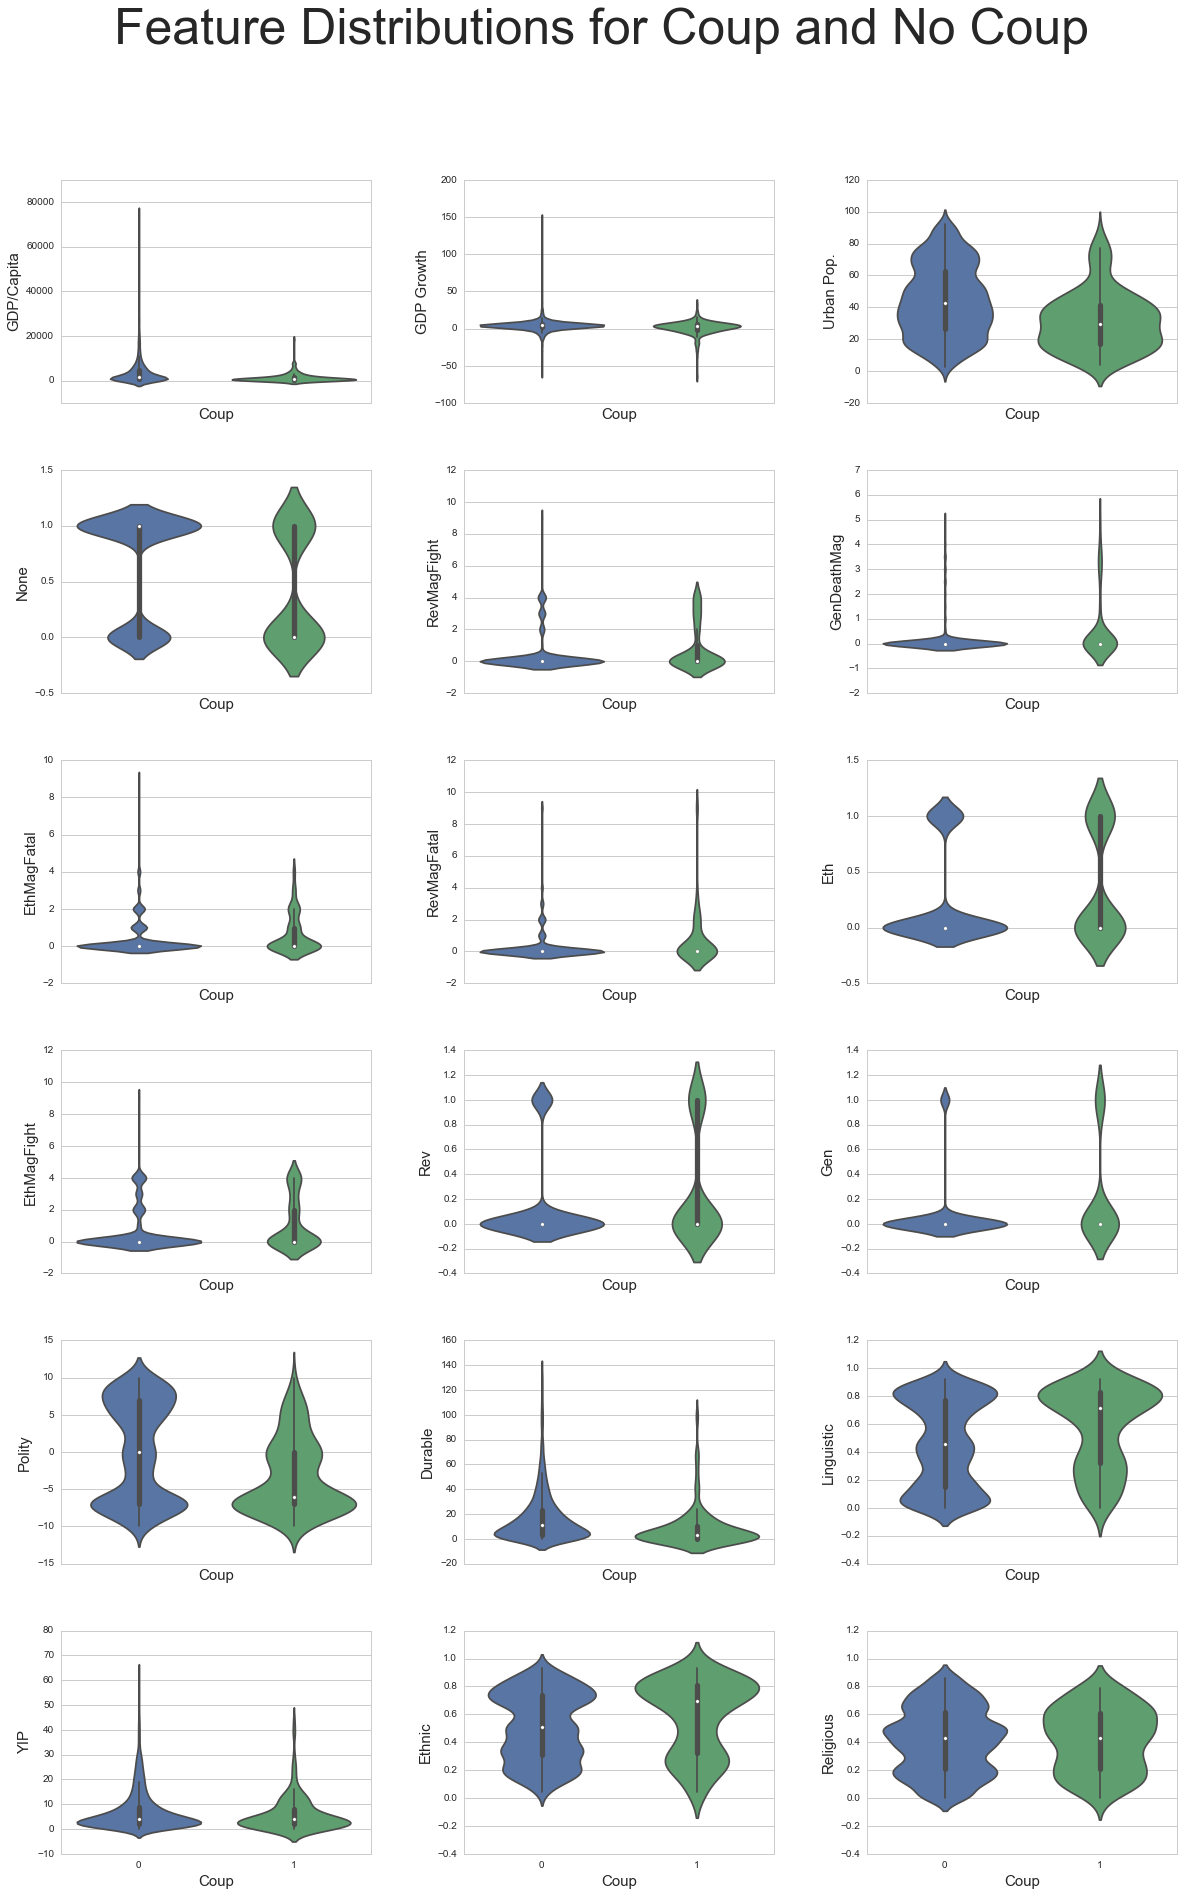

In [424]:
# To observe the differences in distribution of feactures for coup and no coup
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12), \
      (ax13, ax14, ax15), (ax16, ax17, ax18)) = plt.subplots(nrows=6, ncols=3, \
        sharey=False, sharex=True, figsize=(20,30))
fig.suptitle("Feature Distributions for Coup and No Coup", size=50)

sns.set_style("whitegrid")
sns.violinplot(x='coup', y="gdppercap", data=DF, ax=ax1)
ax1.set_xlabel("Coup", fontsize=15)
ax1.set_ylabel("GDP/Capita", fontsize=15)  
    
sns.violinplot(x='coup', y="gdpgrowth", data=DF, ax=ax2)
ax2.set_xlabel("Coup", fontsize=15)
ax2.set_ylabel("GDP Growth", fontsize=15)

sns.violinplot(x='coup', y="urbanpop", data=DF, ax=ax3)
ax3.set_xlabel("Coup", fontsize=15)
ax3.set_ylabel("Urban Pop.", fontsize=15)

sns.violinplot(x='coup', y="none", data=DF, ax=ax4)
ax4.set_xlabel("Coup", fontsize=15)
ax4.set_ylabel("None", fontsize=15)

sns.violinplot(x='coup', y="revmagfight", data=DF, ax=ax5)
ax5.set_xlabel("Coup", fontsize=15)
ax5.set_ylabel("RevMagFight", fontsize=15)

sns.violinplot(x='coup', y="gendeathmag", data=DF, ax=ax6)
ax6.set_xlabel("Coup", fontsize=15)
ax6.set_ylabel("GenDeathMag", fontsize=15)

sns.violinplot(x='coup', y="ethmagfatal", data=DF, ax=ax7)
ax7.set_xlabel("Coup", fontsize=15)
ax7.set_ylabel("EthMagFatal", fontsize=15)

sns.violinplot(x='coup', y="revmagfatal", data=DF, ax=ax8)
ax8.set_xlabel("Coup", fontsize=15)
ax8.set_ylabel("RevMagFatal", fontsize=15)

sns.violinplot(x='coup', y="eth", data=DF, ax=ax9)
ax9.set_xlabel("Coup", fontsize=15)
ax9.set_ylabel("Eth", fontsize=15)

sns.violinplot(x='coup', y="ethmagfight", data=DF, ax=ax10)
ax10.set_xlabel("Coup", fontsize=15)
ax10.set_ylabel("EthMagFight", fontsize=15)

sns.violinplot(x='coup', y="rev", data=DF, ax=ax11)
ax11.set_xlabel("Coup", fontsize=15)
ax11.set_ylabel("Rev", fontsize=15)

sns.violinplot(x='coup', y="gen", data=DF, ax=ax12)
ax12.set_xlabel("Coup", fontsize=15)
ax12.set_ylabel("Gen", fontsize=15)

sns.violinplot(x='coup', y="polity2", data=DF, ax=ax13)
ax13.set_xlabel("Coup", fontsize=15)
ax13.set_ylabel("Polity", fontsize=15)

sns.violinplot(x='coup', y="durable", data=DF, ax=ax14)
ax14.set_xlabel("Coup", fontsize=15)
ax14.set_ylabel("Durable", fontsize=15)

sns.violinplot(x='coup', y="linguistic", data=DF, ax=ax15)
ax15.set_xlabel("Coup", fontsize=15)
ax15.set_ylabel("Linguistic", fontsize=15)

sns.violinplot(x='coup', y="yip", data=DF, ax=ax16)
ax16.set_xlabel("Coup", fontsize=15)
ax16.set_ylabel("YIP", fontsize=15)

sns.violinplot(x='coup', y="ethnic", data=DF, ax=ax17)
ax17.set_xlabel("Coup", fontsize=15)
ax17.set_ylabel("Ethnic", fontsize=15)

sns.violinplot(x='coup', y="religious", data=DF, ax=ax18)
ax18.set_xlabel("Coup", fontsize=15)
ax18.set_ylabel("Religious", fontsize=15)

fig.subplots_adjust(hspace=.3, wspace=.3)

In [425]:
# To split the dataframe into one with instances of a coup and another with instances of no coup
acoup = DF.loc[DF.coup==1]
nocoup = DF.loc[DF.coup==0]

In [426]:
#acoup.head()

In [427]:
#nocoup.head()

In [428]:
acoup.describe()

gdppercap   gdpgrowth    urbanpop   coup        none  revmagfight  \
count    185.000000  185.000000  185.000000  185.0  185.000000   185.000000   
mean    1391.189189    1.426973   31.588270    1.0    0.410811     0.762162   
std     1991.146469    9.429349   18.434825    0.0    0.493316     1.390056   
min       15.000000  -64.050000    3.650000    1.0    0.000000     0.000000   
25%      388.000000   -1.540000   17.220000    1.0    0.000000     0.000000   
50%      583.000000    3.040000   29.670000    1.0    0.000000     0.000000   
75%     1537.000000    5.600000   41.460000    1.0    1.000000     1.000000   
max    18497.000000   32.590000   86.980000    1.0    1.000000     4.000000   

       gendeathmag  ethmagfatal  revmagfatal         eth  ethmagfight  \
count   185.000000   185.000000   185.000000  185.000000   185.000000   
mean      0.532432     0.627027     0.686486    0.367568     1.070270   
std       1.222092     1.003431     1.661286    0.483451     1.557043   
min       0.000000     0.000000     0.000000    0.000000     0.000000   
25%       0.000000     0.000000     0.000000    0.000000     0.000000   
50%       0.000000     0.000000     0.000000    0.000000     0.000000   
75%       0.000000     1.000000     0.000000    1.000000     2.000000   
max       5.000000     4.000000     9.000000    1.000000     4.000000   

              rev         gen     polity2     durable         yip      ethnic  \
count  185.000000  185.000000  185.000000  185.000000  185.000000  185.000000   
mean     0.254054    0.200000   -3.351351    8.664865    6.145946    0.585213   
std      0.436509    0.401085    4.882401   16.002245    7.148677    0.264902   
min      0.000000    0.000000  -10.000000    0.000000    0.000000    0.045400   
25%      0.000000    0.000000   -7.000000    0.000000    2.000000    0.320000   
50%      0.000000    0.000000   -6.000000    3.000000    4.000000    0.693200   
75%      1.000000    0.000000    0.000000   10.000000    8.000000    0.808200   
max      1.000000    1.000000   10.000000  101.000000   44.000000    0.930200   

       linguistic   religious  
count  185.000000  185.000000  
mean     0.578602    0.420310  
std      0.287826    0.224918  
min      0.000000    0.003500  
25%      0.322000    0.209000  
50%      0.719000    0.430700  
75%      0.831600    0.612800  
max      0.922700    0.791600

In [429]:
nocoup.describe()

gdppercap    gdpgrowth     urbanpop    coup         none  \
count   2861.000000  2861.000000  2861.000000  2861.0  2861.000000   
mean    3933.190493     4.160933    44.240566     0.0     0.664453   
std     5817.963331     8.242379    22.407925     0.0     0.472264   
min       10.000000   -62.080000     2.730000     0.0     0.000000   
25%      608.000000     1.760000    26.410000     0.0     0.000000   
50%     1759.000000     4.200000    42.520000     0.0     1.000000   
75%     4839.000000     6.670000    62.720000     0.0     1.000000   
max    75117.000000   149.970000    92.140000     0.0     1.000000   

       revmagfight  gendeathmag  ethmagfatal  revmagfatal          eth  \
count  2861.000000  2861.000000  2861.000000  2861.000000  2861.000000   
mean      0.458231     0.150647     0.379238     0.307235     0.226145   
std       1.231046     0.661391     0.894335     1.043284     0.418407   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       9.000000     5.000000     9.000000     9.000000     1.000000   

       ethmagfight          rev          gen      polity2      durable  \
count  2861.000000  2861.000000  2861.000000  2861.000000  2861.000000   
mean      0.669696     0.141209     0.064663     0.070605    17.478854   
std       1.376230     0.348298     0.245973     6.646934    21.231425   
min       0.000000     0.000000     0.000000   -10.000000     0.000000   
25%       0.000000     0.000000     0.000000    -7.000000     3.000000   
50%       0.000000     0.000000     0.000000     0.000000    11.000000   
75%       0.000000     0.000000     0.000000     7.000000    23.000000   
max       9.000000     1.000000     1.000000    10.000000   135.000000   

               yip       ethnic   linguistic    religious  
count  2861.000000  2861.000000  2861.000000  2861.000000  
mean      7.498777     0.510172     0.460221     0.415175  
std       8.476814     0.244877     0.314458     0.234026  
min       0.000000     0.045400     0.000000     0.003500  
25%       2.000000     0.306900     0.151100     0.209000  
50%       4.000000     0.512200     0.458600     0.430700  
75%       9.000000     0.735100     0.772500     0.615700  
max      63.000000     0.930200     0.922700     0.860300

In [430]:
# To test for statistical differences in the means of features for coup and no coup
features = ["gdppercap", "gdpgrowth", "urbanpop", "none", "revmagfight", 
            "gendeathmag", "ethmagfatal", "revmagfatal", "eth", 
            "ethmagfight", "rev", "gen", "polity2", "durable", 
            "yip", "ethnic", "linguistic", "religious"]

for i in features:
    print ttest_ind(acoup[i], nocoup[i])

Ttest_indResult(statistic=-5.919618873274282, pvalue=3.5867804925411991e-09)
Ttest_indResult(statistic=-4.3321568133553718, pvalue=1.5243048291309258e-05)
Ttest_indResult(statistic=-7.5167743330847685, pvalue=7.3408555191078861e-14)
Ttest_indResult(statistic=-7.0603065923278052, pvalue=2.0494248219305904e-12)
Ttest_indResult(statistic=3.2277506039335551, pvalue=0.0012609191611862298)
Ttest_indResult(statistic=7.1082422976939483, pvalue=1.4580017622241313e-12)
Ttest_indResult(statistic=3.6240186924695066, pvalue=0.00029480620529312711)
Ttest_indResult(statistic=4.5838409159708329, pvalue=4.7489193832549189e-06)
Ttest_indResult(statistic=4.4110929274345656, pvalue=1.0641682817077235e-05)
Ttest_indResult(statistic=3.804759868485299, pvalue=0.00014473347091424949)
Ttest_indResult(statistic=4.198995599398363, pvalue=2.7578757789371637e-05)
Ttest_indResult(statistic=6.914485285799695, pvalue=5.6981771313569814e-12)
Ttest_indResult(statistic=-6.8827588518098972, pvalue=7.0993159573583768e-12)

## Data Exploration

In [431]:
DF.groupby("polity2").mean()

gdppercap  gdpgrowth   urbanpop      coup      none  revmagfight  \
polity2                                                                        
-10       9190.000000   8.205625  46.028750  0.031250  0.718750     0.625000   
-9        2738.840580   4.097295  40.967681  0.077295  0.748792     0.130435   
-8        3810.839623   4.242264  44.474434  0.047170  0.594340     0.613208   
-7        2004.344771   4.393758  35.105507  0.102941  0.691176     0.295752   
-6        3021.279570   4.877527  41.552527  0.059140  0.731183     0.462366   
-5        1813.490909   3.964545  29.498182  0.090909  0.472727     0.854545   
-4        1139.538462   3.460192  27.925192  0.134615  0.346154     0.365385   
-3        2616.706522   4.622391  39.838478  0.043478  0.554348     0.880435   
-2        2215.903226   4.330000  29.319516  0.112903  0.693548     0.758065   
-1        1003.813953   2.898605  33.159884  0.093023  0.593023     0.523256   
 0        1929.754717   2.191698  41.507170  0.125786  0.264151     1.572327   
 1        1207.169492   3.596271  33.422034  0.084746  0.644068     1.101695   
 2        1420.140625   5.078438  43.505781  0.078125  0.781250     0.421875   
 3        3221.235294   3.919804  44.925686  0.117647  0.392157     0.705882   
 4        3686.640845   2.497254  38.106972  0.014085  0.584507     0.739437   
 5        1336.081633   4.657823  34.985510  0.047619  0.680272     0.210884   
 6        6289.412060   4.035226  53.585678  0.030151  0.668342     0.175879   
 7        3386.593220   3.330113  53.482542  0.011299  0.621469     0.627119   
 8        3990.331950   4.027718  54.972739  0.016598  0.626556     0.468880   
 9        6055.739583   4.197604  54.722344  0.000000  0.776042     0.317708   
 10      20037.344000   3.015040  72.318080  0.008000  0.896000     0.000000   

         gendeathmag  ethmagfatal  revmagfatal       eth  ethmagfight  \
polity2                                                                 
-10         0.000000     0.000000     0.281250  0.000000     0.000000   
-9          0.207729     0.299517     0.357488  0.193237     0.613527   
-8          0.330189     0.320755     0.415094  0.207547     0.716981   
-7          0.383987     0.429739     0.245098  0.222222     0.710784   
-6          0.129032     0.204301     0.220430  0.107527     0.263441   
-5          0.090909     0.581818     0.581818  0.454545     1.090909   
-4          0.278846     0.826923     0.134615  0.576923     1.365385   
-3          0.163043     0.423913     0.456522  0.315217     0.804348   
-2          0.161290     0.177419     0.516129  0.112903     0.322581   
-1          0.093023     0.395349     0.302326  0.302326     0.767442   
 0          0.506289     1.125786     1.176101  0.396226     1.421384   
 1          0.000000     0.203390     0.406780  0.152542     0.322034   
 2          0.093750     0.125000     0.234375  0.046875     0.171875   
 3          0.382353     0.960784     1.607843  0.509804     1.843137   
 4          0.014085     0.288732     0.246479  0.274648     0.647887   
 5          0.051020     0.537415     0.115646  0.272109     0.775510   
 6          0.037688     0.402010     0.105528  0.276382     0.909548   
 7          0.073446     0.282486     0.372881  0.175141     0.553672   
 8          0.016598     0.336100     0.323651  0.257261     0.651452   
 9          0.000000     0.286458     0.125000  0.203125     0.666667   
 10         0.000000     0.088000     0.000000  0.104000     0.128000   

              rev       gen    durable        yip    ethnic  linguistic  \
polity2                                                                   
-10      0.281250  0.000000  21.250000  11.187500  0.509519    0.478419   
-9       0.062802  0.091787  23.294686  13.241546  0.526300    0.494781   
-8       0.216981  0.094340  22.094340  12.745283  0.547953    0.473160   
-7       0.084967  0.161765  19.571895   7.557190  0.569001    0.463629   
-6       0.155914  0.086022  26.301075   

In [432]:
DF.groupby("coup").mean()

gdppercap  gdpgrowth   urbanpop      none  revmagfight  gendeathmag  \
coup                                                                          
0     3933.190493   4.160933  44.240566  0.664453     0.458231     0.150647   
1     1391.189189   1.426973  31.588270  0.410811     0.762162     0.532432   

      ethmagfatal  revmagfatal       eth  ethmagfight       rev       gen  \
coup                                                                        
0        0.379238     0.307235  0.226145     0.669696  0.141209  0.064663   
1        0.627027     0.686486  0.367568     1.070270  0.254054  0.200000   

       polity2    durable       yip    ethnic  linguistic  religious  
coup                                                                  
0     0.070605  17.478854  7.498777  0.510172    0.460221   0.415175  
1    -3.351351   8.664865  6.145946  0.585213    0.578602   0.420310

In [433]:
# DF["country"] = DF["country"].astype("category")
# cat_columns = DF.select_dtypes(['category']).columns
# DF[cat_columns] = DF[cat_columns].apply(lambda x: x.cat.codes)

In [434]:
# DF.to_csv("../assets/csv/finalData.csv")

In [435]:
DF["eth"].unique()

array([ 0.,  1.])

In [436]:
worldMap = {
            "southAmerica": ["Argentina", "Chile", "Colombia", "Peru"],
            "centralAmerica": ["El Salvador", "Guatemala", "Mexico", "Nicaragua"],
            "caribbean": ["Cuba", "Dominican Republic", ],
            "northernEurope": ["United Kingdom"],
            "southernEurope": ["Albania", "Croatia"],
            "easternEurope": ["Hungary", "Moldova", "Romania", "Russia", "Ukraine"],
            "centralAsia": ["Tajikistan"],
            "southEasternAsia": ["Cambodia", "Indonesia", "Laos", "Philippines", "Thailand"],
            "southernAsia": ["Afghanistan", "Bangladesh", "India", "Iran", "Nepal","Pakistan", "Sri Lanka"],
            "easternAsia": ["China"],
            "westernAsia": ["Azerbaijan", "Cyprus", "Georgia", "Iraq", "Israel", "Lebanon", "Oman", "Syria", "Turkey"],
            "oceania": ["Papua New Guinea"],
            "northernAfrica": ["Algeria", "Egypt", "Libya", "Morocco", "Sudan"],
            "southernAfrica": ["South Africa"],
            "easternAfrica": ["Burundi", "Djibouti", "Ethiopia", "Kenya", "Mozambique", "Rwanda", "Uganda", "Zambia", "Zimbabwe"],
            "westernAfrica": ["Guinea", "Guinea-Bissau", "Liberia", "Mali", "Nigeria", "Senegal", "Sierra Leone"],
            "middleAfrica": ["Angola", "Central African Republic", "Chad", "DR Congo", "Equatorial Guinea"]
}

In [437]:
def binCountry(country, worldMap):
    for region, countryList in worldMap.items():
        if country in countryList:
            return region
        

DF["CountryBin"] = DF.country.apply( lambda country: binCountry(country, worldMap) )
dummies = pd.get_dummies( DF["CountryBin"] )
DF2 = DF.join(dummies)
DF2.drop(["country", "CountryBin"], axis=1, inplace=True)

In [438]:
DF2.head()

gdppercap  gdpgrowth  urbanpop  coup  none  revmagfight  gendeathmag  \
1      287.0       4.04     11.53     0   1.0            0          0.0   
2      291.0       3.88     11.92     0   1.0            0          0.0   
3      294.0       3.74     12.32     0   1.0            0          0.0   
4      297.0       3.60     12.73     1   1.0            0          0.0   
5      300.0       3.48     13.15     0   1.0            0          0.0   

   ethmagfatal  revmagfatal  eth     ...       northernAfrica  northernEurope  \
1            0            0  0.0     ...                  0.0             0.0   
2            0            0  0.0     ...                  0.0             0.0   
3            0            0  0.0     ...                  0.0             0.0   
4            0            0  0.0     ...                  0.0             0.0   
5            0            0  0.0     ...                  0.0             0.0   

   oceania  southAmerica  southEasternAsia  southernAfrica  southernAsia  \
1      0.0           0.0               0.0             0.0           1.0   
2      0.0           0.0               0.0             0.0           1.0   
3      0.0           0.0               0.0             0.0           1.0   
4      0.0           0.0               0.0             0.0           1.0   
5      0.0           0.0               0.0             0.0           1.0   

   southernEurope  westernAfrica  westernAsia  
1             0.0            0.0          0.0  
2             0.0            0.0          0.0  
3             0.0            0.0          0.0  
4             0.0            0.0          0.0  
5             0.0            0.0          0.0  

[5 rows x 36 columns]

In [439]:
y = DF2["coup"]
X = DF2.drop(["coup"], axis=1)

## Decision Tree Classifier

In [440]:
from sklearn.cross_validation import KFold,cross_val_score,train_test_split,cross_val_predict
from sklearn.metrics import r2_score,accuracy_score,precision_score,recall_score
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
import pydot

In [441]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [442]:
dt = DecisionTreeClassifier() 

dtparam_grid = { 
                "criterion": ["gini", "entropy"],
                "splitter": ["best", "random"],
                "max_features": ["auto", "sqrt", "log2"],
                "min_samples_split": [1,2,3,4,5,6]
               }

CV_dt= GridSearchCV(estimator=dt, param_grid=dtparam_grid, cv=5)
CV_dt.fit(X_train, y_train)
print CV_dt.best_params_
print CV_dt.best_estimator_

{'max_features': 'auto', 'min_samples_split': 5, 'criterion': 'entropy', 'splitter': 'random'}
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='random')


In [448]:
dt = DecisionTreeClassifier(class_weight=None, criterion="entropy", max_depth=None,
            max_features="auto", max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter="random")

dtScore = cross_val_score(dt, X_train, y_train, cv=5,n_jobs=1)
print "Decision Tree scores are:", dtScore
print "Decision Tree average score is:", dtScore.mean()

Decision Tree scores are: [ 0.92974239  0.92271663  0.93896714  0.92723005  0.91314554]
Decision Tree average score is: 0.92636034788


In [449]:
dtModel = dt.fit(X_train, y_train)

In [450]:
dtPredicted = dtModel.predict(X_test)
dtProbs = dtModel.predict_proba(X_test)

In [451]:
dtPredictions = pd.DataFrame()
dtPredictions["Actual"] = y_test
dtPredictions["Predicted"] = dtPredicted
dtPredictions["ProbsPos"], dtPredictions["ProbsNeg"] = zip(*dtProbs)

In [474]:
dtThreshold = 0.08
dtPredictions["ThreshPred"] = [0 if x < dtThreshold else 1 for x in dtPredictions["ProbsNeg"]]

In [475]:
print accuracy_score(dtPredictions["Actual"], dtPredictions["ThreshPred"])
print roc_auc_score(dtPredictions["Actual"], dtPredictions["ThreshPred"])

0.852297592998
0.572557942639


In [476]:
print pd.crosstab(dtPredictions["Actual"], dtPredictions["ThreshPred"], rownames=["Actual"])

ThreshPred    0   1
Actual             
0           765  94
1            41  14


In [477]:
dtPredictions["ThreshPred"].value_counts()

0    806
1    108
Name: ThreshPred, dtype: int64

In [478]:
dtPredictions["Actual"].value_counts()

0    859
1     55
Name: Actual, dtype: int64

In [479]:
dot_data = StringIO()  
export_graphviz(dt, out_file=dot_data,  
                #feature_names=XTemp.columns,  
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

## Random Forest Classifier

In [480]:
rf = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=100, oob_score = True) 

rfparam_grid = { 
                'n_estimators': [25, 50,75,100,125,150],
                'criterio  n': ["gini", "entropy"],
                'max_features': [None, 'sqrt', 'log2'],
                'min_samples_split':[1,2,3,4,5,6]
              }
    
CV_rf = GridSearchCV(estimator=rf, param_grid=rfparam_grid, cv=5)
CV_rf.fit(X_train, y_train)
print CV_rf.best_params_

{'max_features': 'log2', 'min_samples_split': 6, 'criterion': 'entropy', 'n_estimators': 75}


In [481]:
cv = KFold(len(y_train), shuffle=False) 
print cv
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features="log2", max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=1,
            oob_score=True, random_state=20, verbose=0, warm_start=False)
rfScore = cross_val_score(rf, X_train, y_train, cv=cv, n_jobs=-1)
print "Regular Decision Tree scores are:", rfScore
print "Regular Decision Tree average score is:", rfScore.mean()

sklearn.cross_validation.KFold(n=2132, n_folds=3, shuffle=False, random_state=None)
Regular Decision Tree scores are: [ 0.94233474  0.93389592  0.93802817]
Regular Decision Tree average score is: 0.938086276685


In [482]:
rfModel = rf.fit(X_train, y_train)

In [483]:
rfPredicted = rfModel.predict(X_test)
rfProbs = rfModel.predict_proba(X_test)

In [352]:
rfPredictions = pd.DataFrame()
rfPredictions["Actual"] = y_test
rfPredictions["Predicted"] = rfPredicted
rfPredictions["ProbsPos"], rfPredictions["ProbsNeg"] = zip(*rfProbs)

In [484]:
# rfThreshold = 0.10
# rfPredictions["ThreshPred"] = [0 if x < rfThreshold else 1 for x in rfPredictions['ProbsNeg']]

In [505]:
newList = []
newList2 = []
for i in np.arange(0,1,0.01):
    rfPredictions["ThreshPred"] = ([0 if x < i else 1 for x in rfPredictions['ProbsNeg']])
    newList.append(roc_auc_score(rfPredictions["Actual"], rfPredictions["ThreshPred"]))
    newList2.append(i)
d = zip(newList, newList2)
max(d)

(0.72061593819451797, 0.10000000000000001)

In [486]:
rfThreshold = max(d)[1]
rfPredictions["ThreshPred"] = ([0 if x < rfThreshold else 1 for x in rfPredictions['ProbsNeg']])

In [487]:
print accuracy_score(rfPredictions["Actual"], rfPredictions["ThreshPred"])
print roc_auc_score(rfPredictions["Actual"], rfPredictions["ThreshPred"])

0.810722100656
0.720615938195


In [488]:
print pd.crosstab(rfPredictions["Actual"], rfPredictions["ThreshPred"], rownames=["Actual"])

ThreshPred    0    1
Actual              
0           707  152
1            21   34


In [489]:
rfPredictions["ThreshPred"].value_counts()

0    728
1    186
Name: ThreshPred, dtype: int64

In [490]:
rfPredictions["Actual"].value_counts()

0    859
1     55
Name: Actual, dtype: int64

In [491]:
rfPredictions.head()

Actual  Predicted  ProbsPos  ProbsNeg  ThreshPred
457        0          0  0.598094  0.401906           1
1627       0          0  0.998333  0.001667           0
2096       0          0  1.000000  0.000000           0
2214       1          0  0.986667  0.013333           0
2670       0          0  1.000000  0.000000           0

In [492]:
#averaginng feature importances across trees in random forest model
all(rf.feature_importances_ == np.mean([tree.feature_importances_ for tree in rf.estimators_], axis=0))

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

(array([-0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ]),
 <a list of 6 Text yticklabel objects>)

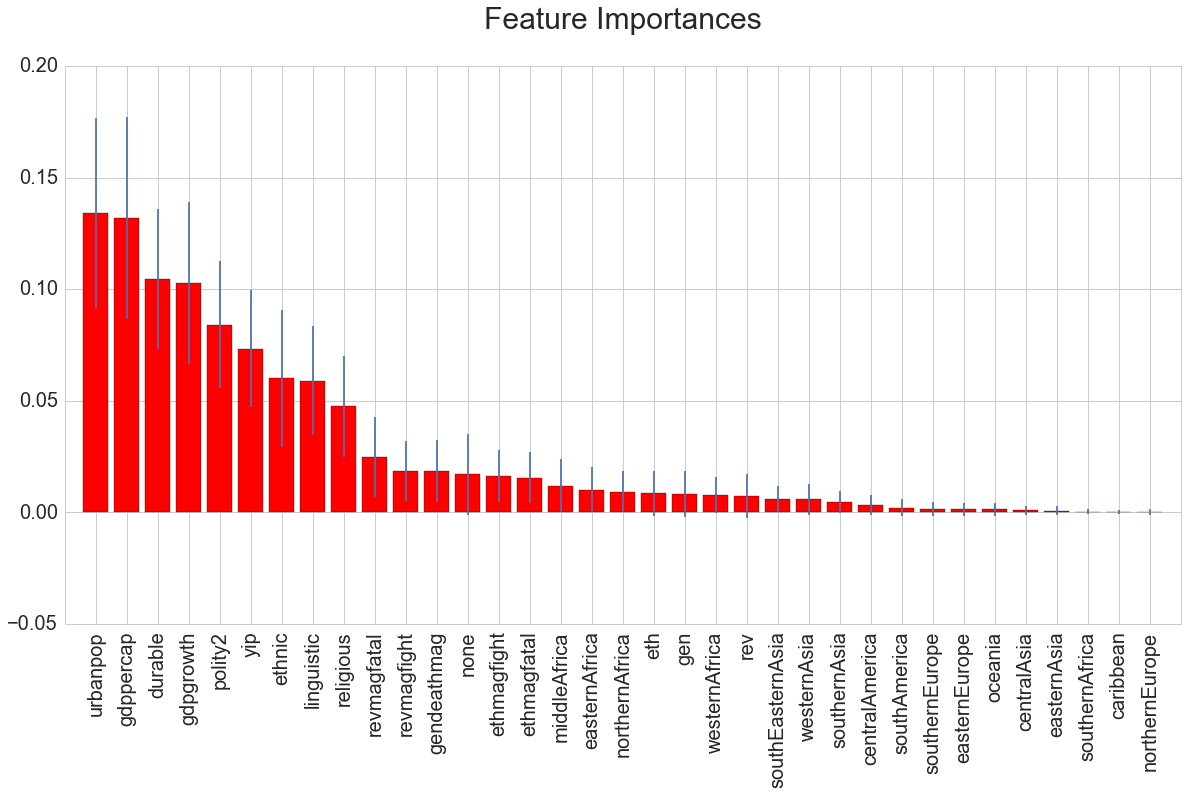

In [493]:
plt.figure(figsize=(20,10))
plt.title("Feature Importances\n", fontsize = 30)
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90, fontsize = 20)
plt.xlim([-1, X_train.shape[1]])
plt.yticks(fontsize=20)

## Random Forest with Feature Selection

In [510]:
X_new = DF[["gdppercap", "urbanpop", "gdpgrowth", "durable", "yip",
            "polity2", "ethnic", "linguistic"]]

In [511]:
X_newtrain, X_newtest, y_newtrain, y_newtest = train_test_split(X_new, y, test_size=0.3, random_state=0)

In [512]:
rf2 = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=100, oob_score = True) 

rf2param_grid = { 
                'n_estimators': [50,75,100,125,150],
                'criterion': ["gini", "entropy"],
                'max_features': [None, 'sqrt', 'log2'],
                'min_samples_split':[1,2,3,4,5,6]
              }
    
CV_rf2 = GridSearchCV(estimator=rf2, param_grid=rf2param_grid, cv=5)
CV_rf2.fit(X_newtrain, y_newtrain)
print CV_rf2.best_params_

{'max_features': 'sqrt', 'min_samples_split': 6, 'criterion': 'entropy', 'n_estimators': 75}


In [497]:
cv2 = KFold(len(y_newtrain), shuffle=False) 
print cv2
rf2 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features="sqrt", max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=125, n_jobs=1,
            oob_score=True, random_state=20, verbose=0, warm_start=False)
rfScore = cross_val_score(rf, X_train, y_train, cv=cv, n_jobs=-1)
print "Regular Decision Tree scores are:", rfScore
print "Regular Decision Tree average score is:", rfScore.mean()

sklearn.cross_validation.KFold(n=2132, n_folds=3, shuffle=False, random_state=None)
Regular Decision Tree scores are: [ 0.94233474  0.93389592  0.93802817]
Regular Decision Tree average score is: 0.938086276685


In [498]:
rf2Model = rf2.fit(X_newtrain, y_newtrain)

In [499]:
rf2Predicted = rf2Model.predict(X_newtest)
rf2Probs = rf2Model.predict_proba(X_newtest)

In [500]:
rf2Predictions = pd.DataFrame()
rf2Predictions["Actual"] = y_newtest
rf2Predictions["Predicted"] = rf2Predicted
rf2Predictions["ProbsPos"], rf2Predictions["ProbsNeg"] = zip(*rf2Probs)

In [507]:
newList = []
newList2 = []
for i in np.arange(0,1,0.01):
    rf2Predictions["ThreshPred"] = ([0 if x < i else 1 for x in rf2Predictions['ProbsNeg']])
    newList.append(roc_auc_score(rf2Predictions["Actual"], rf2Predictions["ThreshPred"]))
    newList2.append(i)
c = zip(newList, newList2)
max(c)

(0.71556778495078854, 0.050000000000000003)

In [508]:
rf2Threshold = max(c)[1]
rf2Predictions["ThreshPred"] = [0 if x < rf2Threshold else 1 for x in rf2Predictions['ProbsNeg']]

In [509]:
print accuracy_score(rf2Predictions["Actual"], rf2Predictions["ThreshPred"])
print roc_auc_score(rf2Predictions["Actual"], rf2Predictions["ThreshPred"])

0.689277899344
0.715567784951


In [96]:
# Compute ROC curve and ROC area for Random Forest
rffpr2 = dict()
rftpr2 = dict()
rfroc_auc2 = dict()
rffpr2, rftpr2, _ = roc_curve(y_newtest, rf2Predictions.ProbsNeg)
rfroc_auc2 = auc(rffpr2, rftpr2)

# Plot of a ROC curve 
plt.figure(figsize=(15,15))
plt.plot(rffpr2,rftpr2,label='Rf AUC = %0.2f' % rfroc_auc2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('Receiver Operating Characteristic\n', fontsize=30)
plt.legend(loc="lower right", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.show()

## AdaBoost Classifier

In [97]:
# ab = AdaBoostClassifier() 

# abparam_grid = { 
#                 "n_estimators": [5,10,15,20,25,30],
#                 "learning_rate": [1.0,2.0,3.0,4.0,5.0,6.0],
#                 "algorithm": ["SAMME", "SAMME.R"]
#               }

# CV_ab= GridSearchCV(estimator=ab, param_grid=abparam_grid, cv=5)
# CV_ab.fit(X_train, y_train)
# print CV_ab.best_params_
# print CV_ab.best_estimator_

In [98]:
cv = KFold(len(y_train), shuffle=False) 
print cv
ab = AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=1.0, n_estimators=5, random_state=20)

abScore = cross_val_score(ab, X_train, y_train, cv=cv,n_jobs=1)
print "Adaboost Decision Tree scores are:", abScore
print "Adaboost Decision Tree average score is:", abScore.mean()

sklearn.cross_validation.KFold(n=2132, n_folds=3, shuffle=False, random_state=None)
Adaboost Decision Tree scores are: [ 0.94233474  0.93530239  0.93943662]
Adaboost Decision Tree average score is: 0.939024583507


In [99]:
abModel = ab.fit(X_train, y_train)

In [100]:
abPredicted = abModel.predict(X_test)
abProbs = abModel.predict_proba(X_test)

In [101]:
abPredictions = pd.DataFrame()
abPredictions["Actual"] = y_test
abPredictions["Predicted"] = abPredicted
abPredictions["ProbsPos"], abPredictions["ProbsNeg"] = zip(*abProbs)

In [102]:
abThreshold = 0.39
abPredictions["ThreshPred"] = [0 if x < abThreshold else 1 for x in abPredictions["ProbsNeg"]]

In [103]:
print accuracy_score(abPredictions["Actual"], abPredictions["ThreshPred"])
print roc_auc_score(abPredictions["Actual"], abPredictions["ThreshPred"])

0.857768052516
0.643538998836


In [104]:
abPredictions.head()

Actual  Predicted  ProbsPos  ProbsNeg  ThreshPred
457        0          0  0.617750  0.382250           0
1627       0          0  0.665339  0.334661           0
2096       0          0  0.652371  0.347629           0
2214       1          0  0.652371  0.347629           0
2670       0          0  0.641687  0.358313           0

In [105]:
print pd.crosstab(abPredictions["Actual"], abPredictions["ThreshPred"], rownames=["Actual"])

ThreshPred    0   1
Actual             
0           762  97
1            33  22


In [106]:
abPredictions["ThreshPred"].value_counts()

0    795
1    119
Name: ThreshPred, dtype: int64

In [107]:
abPredictions["Actual"].value_counts()

0    859
1     55
Name: Actual, dtype: int64

In [108]:
rfPredictions.ThreshPred.head()

457     1
1627    0
2096    0
2214    0
2670    0
Name: ThreshPred, dtype: int64

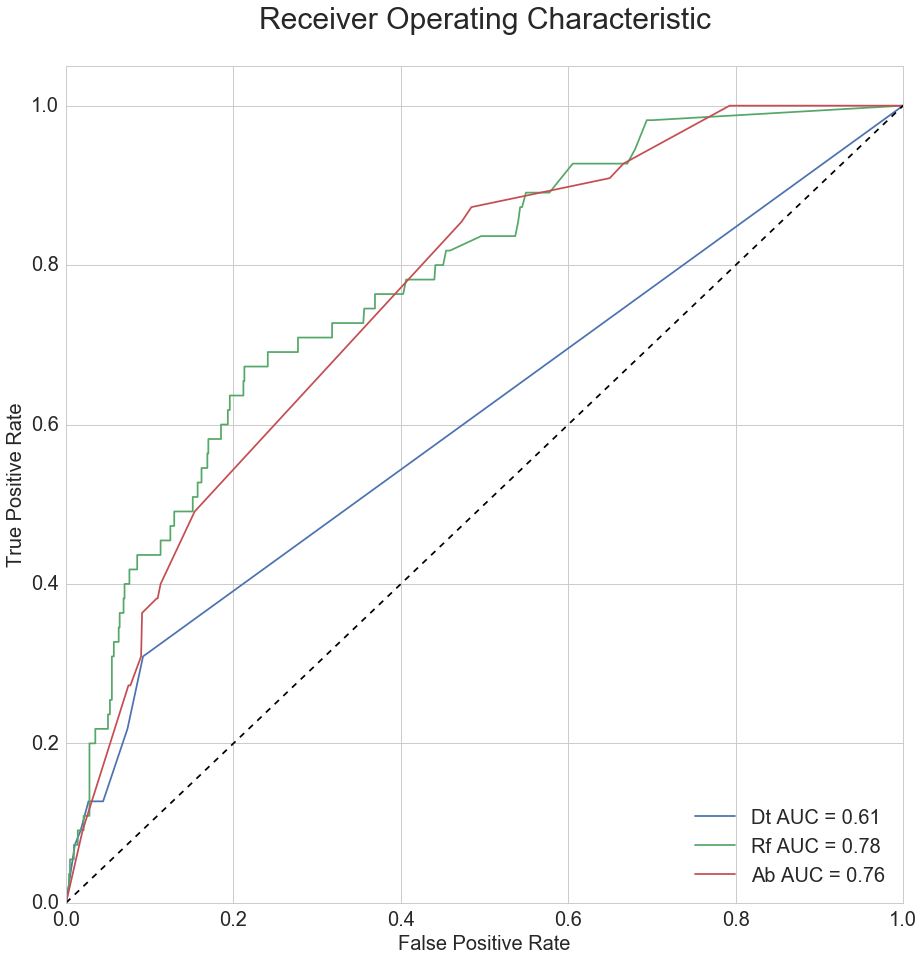

In [284]:
# Compute ROC curve and ROC area for Decision Tree
dtfpr = dict()
dttpr = dict()
dtroc_auc = dict()
dtfpr, dttpr, _ = roc_curve(y_test, dtPredictions.ProbsNeg)
dtroc_auc = auc(dtfpr, dttpr)

# Compute ROC curve and ROC area for Random Forest
rffpr = dict()
rftpr = dict()
rfroc_auc = dict()
rffpr, rftpr, _ = roc_curve(y_test, rfPredictions.ProbsNeg)
rfroc_auc = auc(rffpr, rftpr)

# Compute ROC curve and ROC area for Adaboost
abfpr = dict()
abtpr = dict()
abroc_auc = dict()
abfpr, abtpr, _ = roc_curve(y_test, abPredictions.ProbsNeg)
abroc_auc = auc(abfpr, abtpr)


# Plot of a ROC curve 
plt.figure(figsize=(15,15))
plt.plot(dtfpr,dttpr,label='Dt AUC = %0.2f' % dtroc_auc)
plt.plot(rffpr,rftpr,label='Rf AUC = %0.2f' % rfroc_auc)
plt.plot(abfpr,abtpr,label='Ab AUC = %0.2f' % abroc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('Receiver Operating Characteristic\n', fontsize=30)
plt.legend(loc="lower right", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.show()

## Logistic Regression

In [130]:
from sklearn.linear_model import LogisticRegression

In [131]:
DF.head()

country  gdppercap  gdpgrowth  urbanpop  coup  none  revmagfight  \
1        0      287.0       4.04     11.53     0   1.0            0   
2        0      291.0       3.88     11.92     0   1.0            0   
3        0      294.0       3.74     12.32     0   1.0            0   
4        0      297.0       3.60     12.73     1   1.0            0   
5        0      300.0       3.48     13.15     0   1.0            0   

   gendeathmag  ethmagfatal  revmagfatal  eth  ethmagfight  rev  gen  polity2  \
1          0.0            0            0  0.0            0  0.0  0.0       -7   
2          0.0            0            0  0.0            0  0.0  0.0       -7   
3          0.0            0            0  0.0            0  0.0  0.0       -7   
4          0.0            0            0  0.0            0  0.0  0.0       -7   
5          0.0            0            0  0.0            0  0.0  0.0       -7   

   durable  yip  ethnic  linguistic  religious  
1      6.0   37  0.7693      0.6141     0.2717  
2      7.0   38  0.7693      0.6141     0.2717  
3      8.0   39  0.7693      0.6141     0.2717  
4      9.0   40  0.7693      0.6141     0.2717  
5     10.0    1  0.7693      0.6141     0.2717

In [140]:
DF.to_csv("../assets/final ")

In [141]:
# yl, Xl = dmatrices('affair ~ rate_marriage + age + yrs_married + children + \
#                   religious + educ + C(occupation) + C(occupation_husb)',
#                   dta, return_type="dataframe")